In [1]:
%matplotlib notebook

In [2]:
from simple_network_utils import *
from cell_utils import get_R_inp
from dentate.biophysics_utils import QuickSim
from izhi2007Wrapper import IzhiCell as OrigIzhiCell 

In [3]:
equilibrate = 10.
step_duration = 200.
Rinp_amp = -0.1
cell_type = 'FS'
step_amp_dict = {'IB': [Rinp_amp, 0.290, 0.370, 0.500, 0.550], 'FS': [Rinp_amp, 0.0732, 0.100, 0.200, 0.400]}

In [4]:
orig_cell = OrigIzhiCell(celltype=cell_type, cellid=1)
new_cell = IzhiCell(cell_type=cell_type, gid=0)
sim = QuickSim(cvode=False)
sim.tstop = equilibrate + step_duration

In [5]:
sim.append_stim(cell=new_cell, node=new_cell, name='new_step', amp=0., delay=equilibrate, dur=step_duration)

sim.append_rec(cell=orig_cell, node=orig_cell, name=orig_cell.name, loc=0.5, param='_ref_v')
sim.append_rec(cell=new_cell, node=new_cell, name=new_cell.name, loc=0.5, param='_ref_v')

sim.append_rec(cell=orig_cell, node=orig_cell, name='orig_cell_i', object=orig_cell.izh, loc=0.5, param='_ref_i')
sim.append_rec(cell=new_cell, node=new_cell, name='new_cell_i', object=new_cell.izh, loc=0.5, param='_ref_i')

sim.append_rec(name='orig_cell_u', cell=orig_cell, node=orig_cell, object=orig_cell.izh, param='_ref_u')
sim.append_rec(name='new_cell_u', cell=new_cell, node=new_cell, object=new_cell.izh, param='_ref_u')

<IPython.core.display.Javascript object>


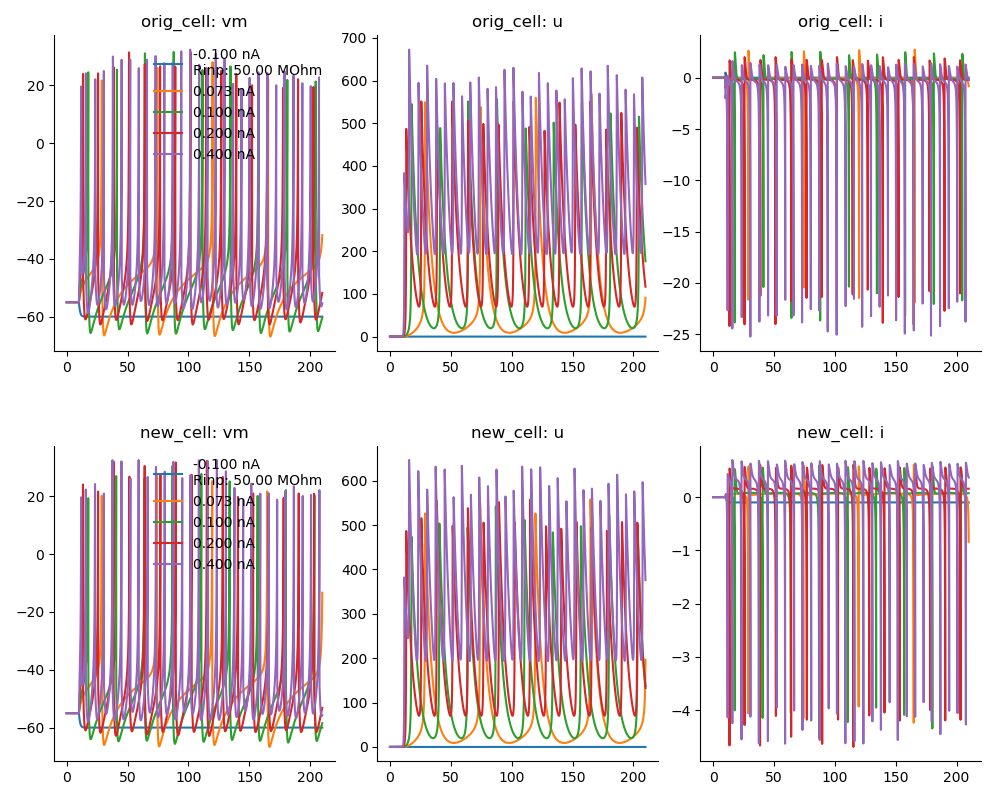

Simulation runtime: 0.05 s
Simulation runtime: 0.05 s
Simulation runtime: 0.04 s
Simulation runtime: 0.04 s
Simulation runtime: 0.04 s


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(10,8))
Rinp = 0.
for step_amp in step_amp_dict[cell_type]:
    sim.modify_stim(name='new_step', amp=step_amp)
    Iin_array = np.zeros(int(sim.tstop / sim.dt))
    Iin_array[int(equilibrate/sim.dt):] = step_amp * 1000.
    Iin_vec = h.Vector(Iin_array)
    Iin_vec.play(orig_cell.izh._ref_Iin, sim.dt)
    sim.run()
    orig_vm_label = '%.3f nA' % step_amp
    new_vm_label = '%.3f nA' % step_amp
    if step_amp == Rinp_amp:
        orig_Rinp = get_R_inp(amp=step_amp, dt=sim.dt, start=equilibrate, stop=sim.tstop, t=np.array(sim.tvec),
                 vm=np.array(sim.recs[orig_cell.name]['vec']))[2]
        orig_vm_label = orig_vm_label + '\nRinp: %.2f MOhm' % orig_Rinp
        new_Rinp = get_R_inp(amp=step_amp, dt=sim.dt, start=equilibrate, stop=sim.tstop, t=np.array(sim.tvec),
                 vm=np.array(sim.recs[orig_cell.name]['vec']))[2]
        new_vm_label = new_vm_label + '\nRinp: %.2f MOhm' % new_Rinp
    
    axes[0][0].plot(np.array(sim.tvec), np.array(sim.recs[orig_cell.name]['vec']), label=orig_vm_label)
    axes[0][0].set_title('orig_cell: vm')
    axes[1][0].plot(np.array(sim.tvec), np.array(sim.recs[new_cell.name]['vec']), label=new_vm_label)
    axes[1][0].set_title('new_cell: vm')
    axes[0][1].plot(np.array(sim.tvec), np.array(sim.recs['orig_cell_u']['vec']))
    axes[0][1].set_title('orig_cell: u')
    axes[1][1].plot(np.array(sim.tvec), np.array(sim.recs['new_cell_u']['vec']))
    axes[1][1].set_title('new_cell: u')
    axes[0][2].plot(np.array(sim.tvec), np.array(sim.recs['orig_cell_i']['vec']))
    axes[0][2].set_title('orig_cell: i')
    axes[1][2].plot(np.array(sim.tvec), np.array(sim.recs['new_cell_i']['vec']))
    axes[1][2].set_title('new_cell: i')
axes[0][0].legend(loc='best', frameon=False, framealpha=0.5)
axes[1][0].legend(loc='best', frameon=False, framealpha=0.5)
clean_axes(axes)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.15)
fig.show()